# **Classifying Student Academic Performance Using Machine Learning**

**Goal:**  
Build and evaluate machine learning models to classify student performance (Low / Medium / High) using academic, behavioural, and socio-economic features.

**Key Steps**
1. Import dataset from the **UCI Machine Learning Repository**  
2. Perform **EDA and preprocessing**  
3. Engineer **Low/Medium/High** target categories from grades  
4. Train **Logistic Regression**, **KNN**, and **SVC** models  
5. Evaluate performance with metrics and visualizations  
6. Interpret model importance using **Permutation Importance**


# **Import Libraries**
This cell installs and imports all necessary libraries for data loading, preprocessing, visualization, and model building.


In [1]:
pip install ucimlrepo

In [2]:

import warnings
warnings.filterwarnings('ignore')
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance

from time import perf_counter
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(" Libraries imported successfully.")


 Libraries imported successfully.


# **Load Dataset from UCI Repository**
We fetch the **Student Performance** dataset (ID = 320) directly using the `ucimlrepo` library.


In [3]:
# Fetch dataset
student_performance = fetch_ucirepo(id=320)

# Extract features and target
X = student_performance.data.features
y = student_performance.data.targets

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Combine into a single DataFrame
df = pd.concat([X, y], axis=1)
print("Combined DataFrame shape:", df.shape)

df.head()


Features shape: (649, 30)
Target shape: (649, 3)
Combined DataFrame shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


# **Exploratory Data Analysis (EDA)**
Let's explore data types, missing values, and summary statistics to understand dataset structure.


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    o

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


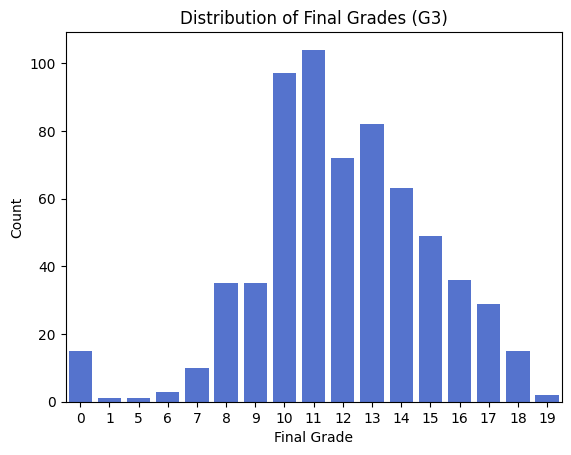

In [4]:
# Display dataset info
print("=== Dataset Info ===")
print(df.info())

# Missing values
print("\n=== Missing Values ===")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Summary statistics
display(df.describe())

# Countplot for target variable
sns.countplot(x='G3', data=df, color='royalblue')
plt.title("Distribution of Final Grades (G3)")
plt.xlabel("Final Grade")
plt.ylabel("Count")
plt.show()


# **Target Engineering — Create Performance Labels**
We convert numeric grades (**G3**) into three performance levels:
- **Low:** 0–9  
- **Medium:** 10–14  
- **High:** 15–20


performance
Medium    418
High      131
Low       100
Name: count, dtype: int64


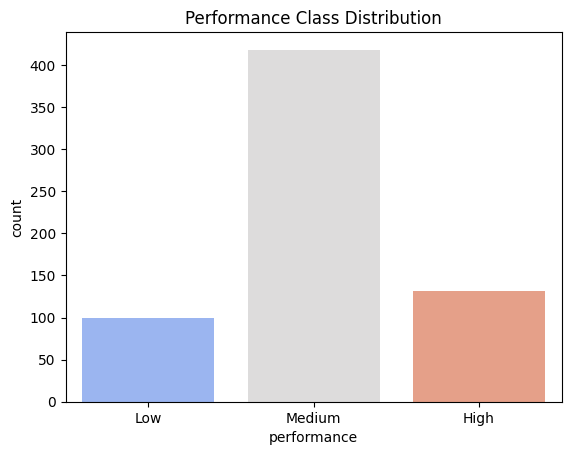

In [5]:
bins = [-1, 9, 14, 20]
labels = ["Low", "Medium", "High"]
df["performance"] = pd.cut(df["G3"], bins=bins, labels=labels)

# Drop rows with missing target if any
df = df.dropna(subset=["performance"])
print(df["performance"].value_counts())

sns.countplot(x='performance', data=df, palette='coolwarm')
plt.title("Performance Class Distribution")
plt.show()


### **Further Data Exploration**

Let's visualize the data to understand feature distributions and relationships.

In [11]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()



print("Numeric columns for plotting:", numeric_cols[:10])
print("Categorical columns for plotting:", categorical_cols[:10])

Numeric columns for plotting: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc']
Categorical columns for plotting: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup']


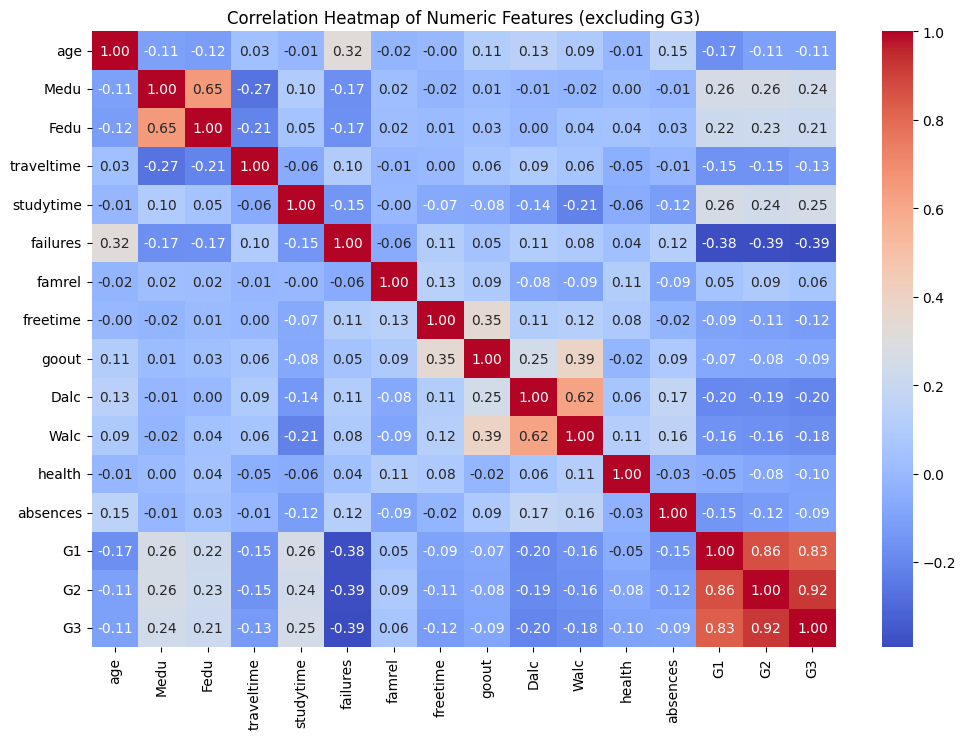

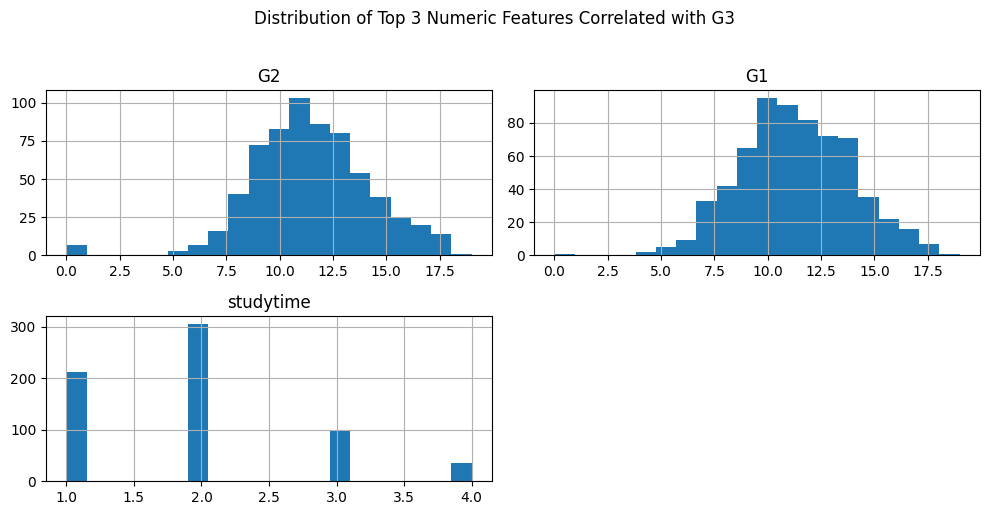

In [12]:
# Correlation heatmap (between numeric features, excluding G3 as per prior processing)
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features (excluding G3)")
plt.show()

# Select top 3 numerical columns most correlated with G3
# For this calculation, we need G3 to be present in the DataFrame
# We will use the full DataFrame for correlation and then extract G3's correlations.
correlations = df.select_dtypes(include=np.number).corr()['G3'].sort_values(ascending=False)

# Exclude G3 itself and then select top 3
top_correlated_cols = correlations.index[1:4].tolist()

# Distribution plots for top correlated numerical features
df[top_correlated_cols].hist(figsize=(10, 5), bins=20)
plt.suptitle("Distribution of Top 3 Numeric Features Correlated with G3", y=1.02)
plt.tight_layout()
plt.show()

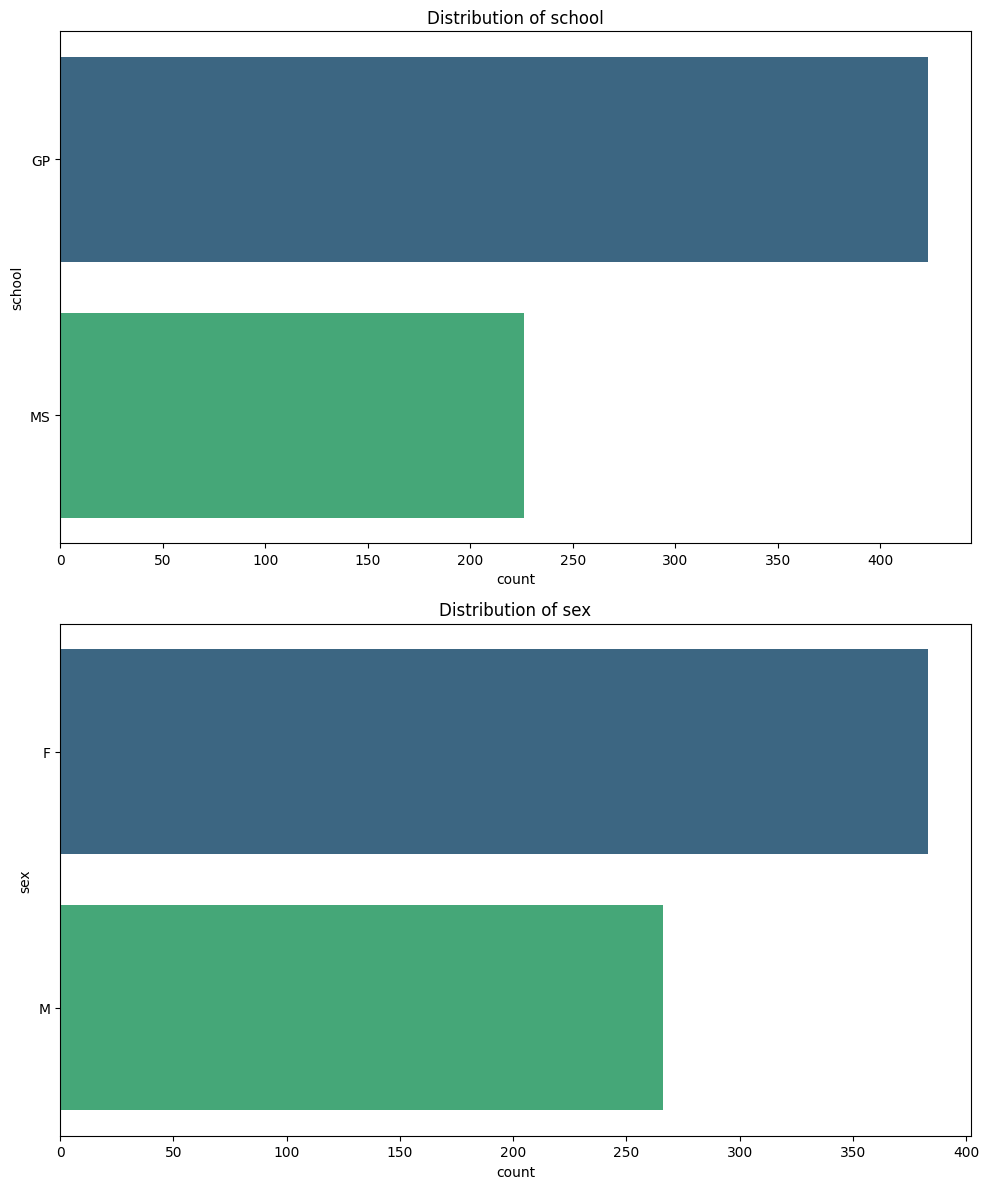

In [13]:
# Distribution plots for categorical features
# You can specify which columns to plot by changing the list below.
cols_to_plot = categorical_cols[:2] # Example: plots the first two categorical columns

fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(10, 6 * len(cols_to_plot)))

# Ensure axes is an array even if only one column is plotted
if len(cols_to_plot) == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    sns.countplot(y=col, data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# **Feature Selection and Preprocessing**
We separate features and target, identify categorical and numerical columns, and create a preprocessing pipeline with:
- **Imputation** for missing values  
- **Standard Scaling** for numerics  
- **One-Hot Encoding** for categoricals


In [14]:
target = "performance"
X = df.drop(columns=["performance"])
y = df[target]

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", numeric_cols[:10])
print("Categorical columns:", categorical_cols[:10])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

print(" Preprocessing pipeline ready.")


Numeric columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc']
Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup']
 Preprocessing pipeline ready.


# **Model Training**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# Fit on train; transform train & test
preprocessor_fitted = preprocessor.fit(X_train)

X_train_proc = preprocessor_fitted.transform(X_train)
X_test_proc  = preprocessor_fitted.transform(X_test)

# Keep the class list for ROC binarization (sorted for stability)
classes = sorted(y.unique())
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

n_classes = len(classes)
print("Processed shapes:", X_train_proc.shape, X_test_proc.shape, "| classes:", classes)


Train size: (519, 33) | Test size: (130, 33)
Processed shapes: (519, 59) (130, 59) | classes: ['High', 'Low', 'Medium']


# **Defining models for training**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        multi_class="auto"
        # optionally: class_weight="balanced"
    ),
    "KNN_k7": KNeighborsClassifier(
        n_neighbors=7
        # optionally: weights="distance", p=1 (Manhattan) or 2 (Euclidean)
    ),
    "SVC_rbf": SVC(
        kernel="rbf",
        probability=True,  # needed for predict_proba and ROC
        random_state=42
        # optionally: C=1.0, gamma="scale"
    )
}



===== LogisticRegression =====
Train time: 0.0550s | Predict time: 0.0006s
Accuracy: 0.9154 | F1-macro: 0.8961 | ROC-AUC (macro OVR): 0.9891

Classification Report:
              precision    recall  f1-score   support

        High     0.9130    0.8077    0.8571        26
         Low     0.9444    0.8500    0.8947        20
      Medium     0.9101    0.9643    0.9364        84

    accuracy                         0.9154       130
   macro avg     0.9225    0.8740    0.8961       130
weighted avg     0.9160    0.9154    0.9141       130



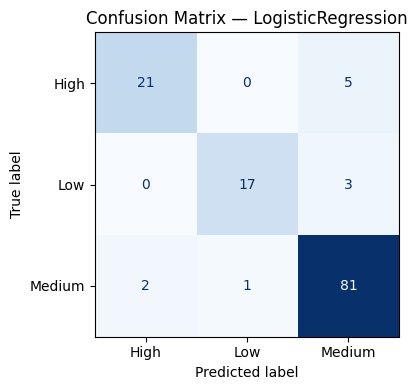


===== KNN_k7 =====
Train time: 0.0031s | Predict time: 0.0472s
Accuracy: 0.8077 | F1-macro: 0.7031 | ROC-AUC (macro OVR): 0.9187

Classification Report:
              precision    recall  f1-score   support

        High     0.8000    0.7692    0.7843        26
         Low     1.0000    0.3000    0.4615        20
      Medium     0.7980    0.9405    0.8634        84

    accuracy                         0.8077       130
   macro avg     0.8660    0.6699    0.7031       130
weighted avg     0.8295    0.8077    0.7858       130



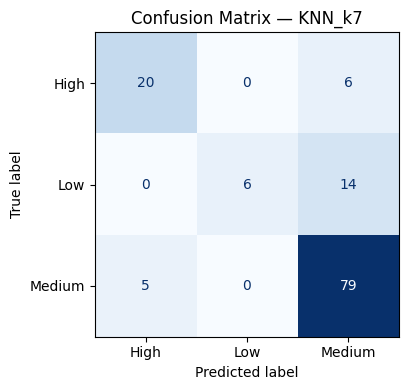


===== SVC_rbf =====
Train time: 0.0776s | Predict time: 0.0047s
Accuracy: 0.8846 | F1-macro: 0.8394 | ROC-AUC (macro OVR): 0.9759

Classification Report:
              precision    recall  f1-score   support

        High     0.9524    0.7692    0.8511        26
         Low     1.0000    0.6000    0.7500        20
      Medium     0.8557    0.9881    0.9171        84

    accuracy                         0.8846       130
   macro avg     0.9360    0.7858    0.8394       130
weighted avg     0.8972    0.8846    0.8782       130



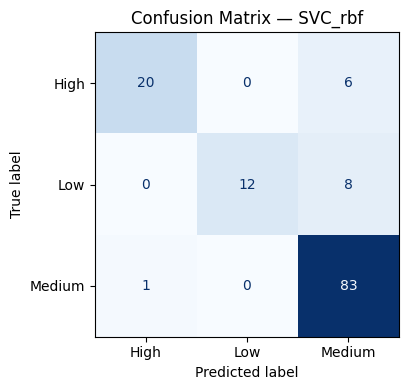

In [ ]:
results = {}

for name, model in models.items():
    # --- Train time
    t0 = perf_counter()
    model.fit(X_train_proc, y_train)
    train_time = perf_counter() - t0

    # --- Predict & proba time
    t1 = perf_counter()
    y_pred = model.predict(X_test_proc)
    pred_time = perf_counter() - t1

    # --- Metrics
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    # Some models expose predict_proba; (all chosen do).
    y_score = model.predict_proba(X_test_proc)

    # ROC-AUC (one-vs-rest, macro)
    roc_auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

    # Store
    results[name] = {
        "model": model,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
        "accuracy": acc,
        "f1_macro": f1m,
        "roc_auc_macro": roc_auc_macro,
        "y_pred": y_pred,
        "y_score": y_score
    }

    # --- Print report
    print(f"\n===== {name} =====")
    print(f"Train time: {train_time:.4f}s | Predict time: {pred_time:.4f}s")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | ROC-AUC (macro OVR): {roc_auc_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # --- Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()


# **ROC Curve for Models**

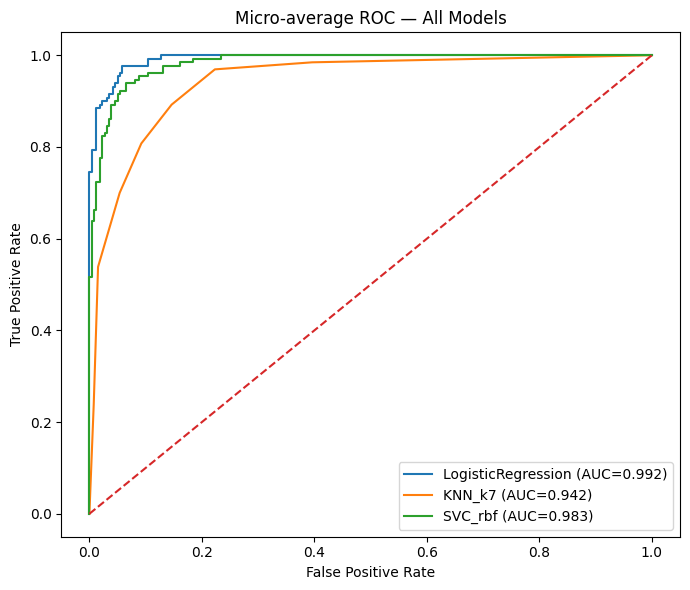

In [ ]:
plt.figure(figsize=(7,6))

for name, res in results.items():
    # Micro-average ROC: treat every class-vs-rest instance as a binary decision and aggregate
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), res["y_score"].ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC — All Models")
plt.legend()
plt.tight_layout()
plt.show()


# **Summarized Result of all models**

In [ ]:
summary = pd.DataFrame([
    {
        "model": name,
        "accuracy": res["accuracy"],
        "f1_macro": res["f1_macro"],
        "roc_auc_macro": res["roc_auc_macro"],
        "train_time_s": res["train_time_s"],
        "pred_time_s": res["pred_time_s"],
    }
    for name, res in results.items()
]).sort_values(by=["roc_auc_macro","f1_macro","accuracy"], ascending=False, ignore_index=True)

summary


,model,accuracy,f1_macro,roc_auc_macro,train_time_s,pred_time_s
0,LogisticRegression,0.915385,0.896099,0.989094,0.054967,0.000558
1,SVC_rbf,0.884615,0.839397,0.975896,0.077642,0.004748
2,KNN_k7,0.807692,0.703080,0.918708,0.003114,0.047154


# **Model's Parameter tuning with Baysian Optimization Technique**

In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00


**Setting up for Optimization**

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from time import perf_counter

# Initialize a list to store tuned results
tuned_results = []

print("Setup complete. Ready to define search spaces.")

Setup complete. Ready to define search spaces.


**Defining search space**

In [ ]:
# Define the search spaces for each model
search_spaces = {
    "LogisticRegression": {
        "model": LogisticRegression(multi_class="auto", max_iter=2000, random_state=42),
        "params": {
            "C": Real(1e-3, 1e+2, prior='log-uniform'),
            "solver": Categorical(['lbfgs', 'liblinear'])
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": Integer(3, 30),
            "weights": Categorical(['uniform', 'distance']),
            "p": Integer(1, 2)  # 1=Manhattan, 2=Euclidean
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": Real(1e-3, 1e+2, prior='log-uniform'),
            "gamma": Real(1e-3, 1e+1, prior='log-uniform'),
            "kernel": Categorical(['rbf']) # Focus on RBF for C/gamma tuning
        }
    }
}

print("Search spaces defined.")

Search spaces defined.


**Optimization Loop**

In [ ]:
from sklearn.preprocessing import LabelEncoder

print("Starting Bayesian Optimization...\n")

# --- FIX: Encode Target Strings to Integers ---
# KNN and BayesSearchCV require integer targets (0, 1, 2) instead of strings ('High', 'Low')
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# Check mapping to ensure you know which integer is which class
print(f"Target Encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")

for name, config in search_spaces.items():
    print(f"--- Tuning {name} ---")

    # Initialize BayesSearchCV
    opt = BayesSearchCV(
        estimator=config["model"],
        search_spaces=config["params"],
        n_iter=30,
        cv=3,
        n_jobs=-1,
        scoring='accuracy',
        random_state=42,
        verbose=0
    )

    # --- Train (Tune)
    t0 = perf_counter()
    # USE ENCODED TARGETS (y_train_enc)
    opt.fit(X_train_proc, y_train_enc)
    train_time = perf_counter() - t0

    # Get best model
    best_model = opt.best_estimator_
    print(f"Best Params: {opt.best_params_}")

    # --- Predict & Evaluate
    t1 = perf_counter()
    y_pred = best_model.predict(X_test_proc)
    pred_time = perf_counter() - t1

    y_score = best_model.predict_proba(X_test_proc)

    # Calculate metrics using ENCODED test labels
    acc = accuracy_score(y_test_enc, y_pred)
    f1m = f1_score(y_test_enc, y_pred, average="macro")

    # ROC-AUC (Requires y_test_bin which you created in the Preprocessing block)
    # Note: We use y_test_bin here because it is already the correct binary matrix format
    roc_auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

    # Store results (We inverse transform y_pred back to strings for clarity in storage)
    tuned_results.append({
        "model": f"Tuned_{name}",
        "best_params": opt.best_params_,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
        "accuracy": acc,
        "f1_macro": f1m,
        "roc_auc_macro": roc_auc_macro,
        "y_pred": le.inverse_transform(y_pred), # Store as original string labels
        "y_score": y_score
    })

    print(f"Accuracy: {acc:.4f} | AUC: {roc_auc_macro:.4f}\n")

Starting Bayesian Optimization...

Target Encoding: {'High': 0, 'Low': 1, 'Medium': 2}
--- Tuning LogisticRegression ---
Best Params: OrderedDict({'C': 59.894912052679324, 'solver': 'liblinear'})
Accuracy: 0.9615 | AUC: 0.9942

--- Tuning KNN ---
Best Params: OrderedDict({'n_neighbors': 12, 'p': 1, 'weights': 'uniform'})
Accuracy: 0.8385 | AUC: 0.9455

--- Tuning SVC ---
Best Params: OrderedDict({'C': 100.0, 'gamma': 0.0012763084345421706, 'kernel': 'rbf'})
Accuracy: 0.9077 | AUC: 0.9836



# **Startified K-Fold Cross Validation**

In [ ]:
# 1. Prepare Target (Encode strings to integers for safety with KNN)
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y))  # Ensure y is a Series with integer labels
classes = sorted(y_encoded.unique())        # [0, 1, 2]

# 2. Define Models with the OPTIMIZED Hyperparameters
models = {
    "LogReg_Tuned": LogisticRegression(
        C=59.894912052679324,
        solver='liblinear',
        max_iter=2000,
        random_state=42
    ),
    "KNN_Tuned": KNeighborsClassifier(
        n_neighbors=12,
        p=1,                  # Manhattan Distance
        weights='uniform'
    ),
    "SVC_Tuned": SVC(
        C=100.0,
        gamma=0.0012763084345421706,
        kernel='rbf',
        probability=True,     # Required for ROC-AUC
        random_state=42
    )
}

# 3. Stratified K-Fold Loop
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Starting 5-Fold CV on {len(models)} tuned models...\n")

for name, base_model in models.items():
    accs, f1s, aucs = [], [], []

    # Note: We use y_encoded here
    for tr, va in skf.split(X, y_encoded):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y_encoded.iloc[tr], y_encoded.iloc[va]

        # A. Fit/Transform Preprocessor inside fold (No data leakage)
        prep = clone(preprocessor).fit(X_tr)
        X_tr_p = prep.transform(X_tr)
        X_va_p = prep.transform(X_va)

        # B. Train Model
        model = clone(base_model).fit(X_tr_p, y_tr)

        # C. Predict
        y_pred = model.predict(X_va_p)
        y_score = model.predict_proba(X_va_p)

        # D. Metrics
        accs.append(accuracy_score(y_va, y_pred))
        f1s.append(f1_score(y_va, y_pred, average="macro"))

        # Binarize labels for ROC-AUC
        y_va_bin = label_binarize(y_va, classes=classes)
        aucs.append(roc_auc_score(y_va_bin, y_score, average="macro", multi_class="ovr"))

    print(f"===== {name} =====")
    print(f"Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1 : {np.mean(f1s):.4f}  ± {np.std(f1s):.4f}")
    print(f"AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}\n")

Starting 5-Fold CV on 3 tuned models...

===== LogReg_Tuned =====
Acc: 0.9491 ± 0.0186
F1 : 0.9362  ± 0.0246
AUC: 0.9880 ± 0.0095

===== KNN_Tuned =====
Acc: 0.8089 ± 0.0145
F1 : 0.6995  ± 0.0243
AUC: 0.9339 ± 0.0181

===== SVC_Tuned =====
Acc: 0.9291 ± 0.0186
F1 : 0.9101  ± 0.0252
AUC: 0.9862 ± 0.0101



# **Analysis of Influential Predictors**

To understand which factors contribute most to student performance, we analyze the **magnitude** of the Logistic Regression coefficients.

Since the data has been scaled (normalized), the absolute value of a feature's coefficient represents its weight in the model's decision-making process. Larger absolute values indicate features that have a stronger predictive power, regardless of whether that impact is positive or negative.

Analyzing coefficients for class: High


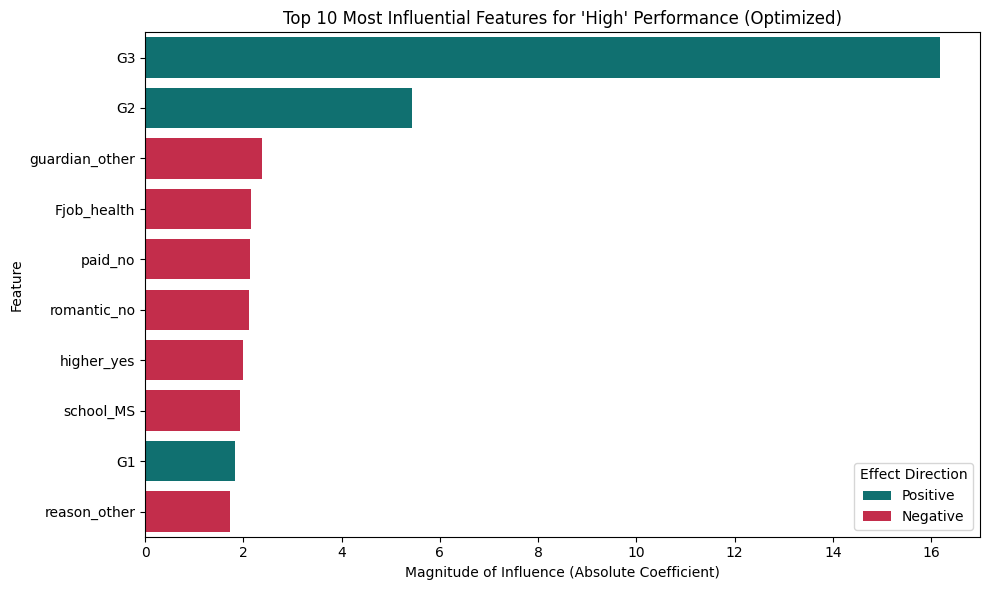

Top 5 Influential Features for High:


,Feature,Importance (Abs Coefficient),Direction
15,G3,16.183501,Positive
14,G2,5.428274,Positive
42,guardian_other,2.382968,Negative
32,Fjob_health,2.163677,Negative
47,paid_no,2.138217,Negative


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Instantiate and Fit the Optimized Model
# We use the best params found from Bayesian Optimization
best_log_reg = LogisticRegression(
    C=59.895,
    solver='liblinear',
    max_iter=2000,
    random_state=42
)

# Fit on the preprocessed training data
best_log_reg.fit(X_train_proc, y_train)

# 2. Get feature names from the fitted preprocessor
feature_names = (
    preprocessor_fitted.named_transformers_['num'].get_feature_names_out().tolist() +
    preprocessor_fitted.named_transformers_['cat'].get_feature_names_out().tolist()
)

# 3. Extract coefficients for the 'High' performance class
# dynamically find the index of "High" in the model's classes
target_class = "High"
high_class_index = np.where(best_log_reg.classes_ == target_class)[0][0]
coeffs = best_log_reg.coef_[high_class_index]

print(f"Analyzing coefficients for class: {best_log_reg.classes_[high_class_index]}")

# 4. Create a DataFrame for importance
# We use absolute value to see the MAGNITUDE of influence
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Abs Coefficient)': np.abs(coeffs),
    'Direction': ["Positive" if c > 0 else "Negative" for c in coeffs]
}).sort_values(by='Importance (Abs Coefficient)', ascending=False).head(10)

# 5. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance (Abs Coefficient)",
    y="Feature",
    data=importance_df,
    hue="Direction",
    dodge=False,
    palette={"Positive": "teal", "Negative": "crimson"}
)
plt.title(f"Top 10 Most Influential Features for '{target_class}' Performance (Optimized)")
plt.xlabel("Magnitude of Influence (Absolute Coefficient)")
plt.legend(title="Effect Direction")
plt.tight_layout()
plt.show()

print(f"Top 5 Influential Features for {target_class}:")
display(importance_df[['Feature', 'Importance (Abs Coefficient)', 'Direction']].head(5))

# **Actionable Insights and Interpretability**

While magnitude tells us *importance*, the **direction** (sign) of the coefficients provides *actionable insights* for educators:

* **Positive Coefficients (+):** Features that actively boost the probability of achieving a "High" grade.
* **Negative Coefficients (-):** Features that are associated with a lower probability of achieving a "High" grade (potential risk factors).

By visualizing these directional impacts, we can distinguish between behaviors that should be encouraged (boosters) and those that require intervention (hurdles).

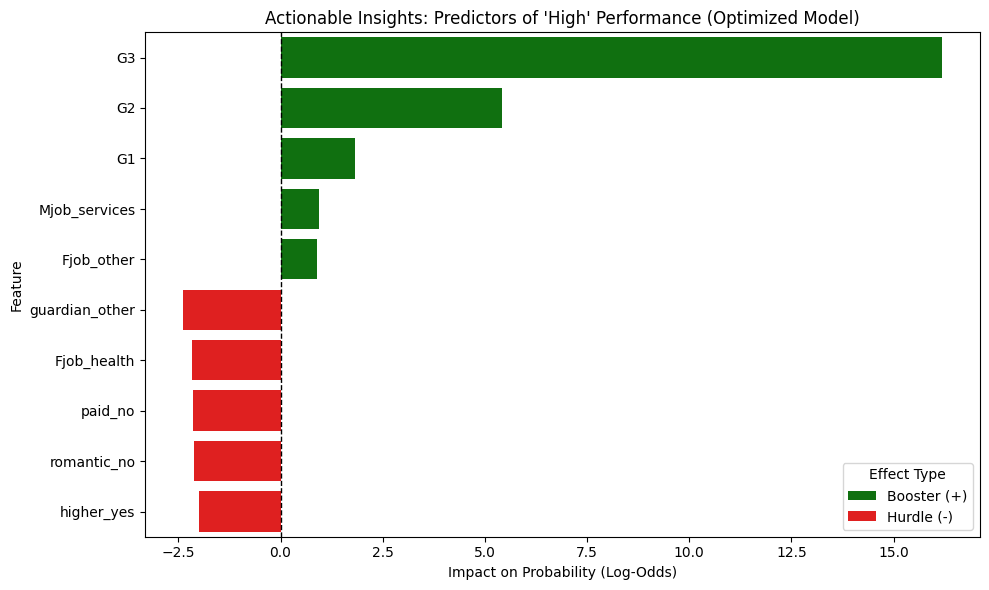

--- INTERPRETATION ---
Green Bars (Booster): Increasing these features INCREASES the likelihood of a High grade.
Red Bars (Hurdle): Increasing these features DECREASES the likelihood of a High grade.


,Feature,Coefficient,Impact
15,G3,16.183501,Booster (+)
14,G2,5.428274,Booster (+)
13,G1,1.819707,Booster (+)
29,Mjob_services,0.936122,Booster (+)
33,Fjob_other,0.904612,Booster (+)
42,guardian_other,-2.382968,Hurdle (-)
32,Fjob_health,-2.163677,Hurdle (-)
47,paid_no,-2.138217,Hurdle (-)
57,romantic_no,-2.114070,Hurdle (-)
54,higher_yes,-1.994059,Hurdle (-)


In [ ]:
# ============================================================
# EXTRACTING ACTIONABLE INSIGHTS (DIRECTIONALITY)
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Reuse coefficients and names from the Optimized Model (previous step)
# Ensure 'feature_names' and 'coeffs' are available from the previous block.
if 'coeffs' not in locals() or 'feature_names' not in locals():
    raise ValueError("Please run the 'Feature Importance' block first to define coeffs/feature_names.")

direction_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs
})

# 2. Sort to find strongest Boosters (Positive) and Hurdles (Negative)
top_positive = direction_df.sort_values(by='Coefficient', ascending=False).head(5)
top_negative = direction_df.sort_values(by='Coefficient', ascending=True).head(5)

# Combine them
insights_df = pd.concat([top_positive, top_negative])

# Add a column for color coding
insights_df['Impact'] = insights_df['Coefficient'].apply(lambda x: 'Booster (+)' if x > 0 else 'Hurdle (-)')

# 3. Visualization
plt.figure(figsize=(10, 6))

# Plot with explicit colors for Positive/Negative
sns.barplot(
    x="Coefficient",
    y="Feature",
    data=insights_df,
    hue="Impact",
    dodge=False,
    palette={'Booster (+)': 'green', 'Hurdle (-)': 'red'}
)

plt.title("Actionable Insights: Predictors of 'High' Performance (Optimized Model)")
plt.xlabel("Impact on Probability (Log-Odds)")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Effect Type")
plt.tight_layout()
plt.show()

print("--- INTERPRETATION ---")
print("Green Bars (Booster): Increasing these features INCREASES the likelihood of a High grade.")
print("Red Bars (Hurdle): Increasing these features DECREASES the likelihood of a High grade.")

display(insights_df[['Feature', 'Coefficient', 'Impact']])